In [1]:
!pip install xgboost

In [2]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------

import pandas as pd
import numpy as np
import os

from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


import matplotlib.pyplot as plt
import seaborn as sns


# clean data

In [3]:
data=pd.read_csv('data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
data=data[data.columns.drop(data.columns[[0,-1]])] #drop first and last columns
data.shape

(569, 31)

In [5]:
data.isnull().sum() #wow very clean and nice data

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

# Exploratory data analysis

C:\Users\Ween\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x864 with 0 Axes>

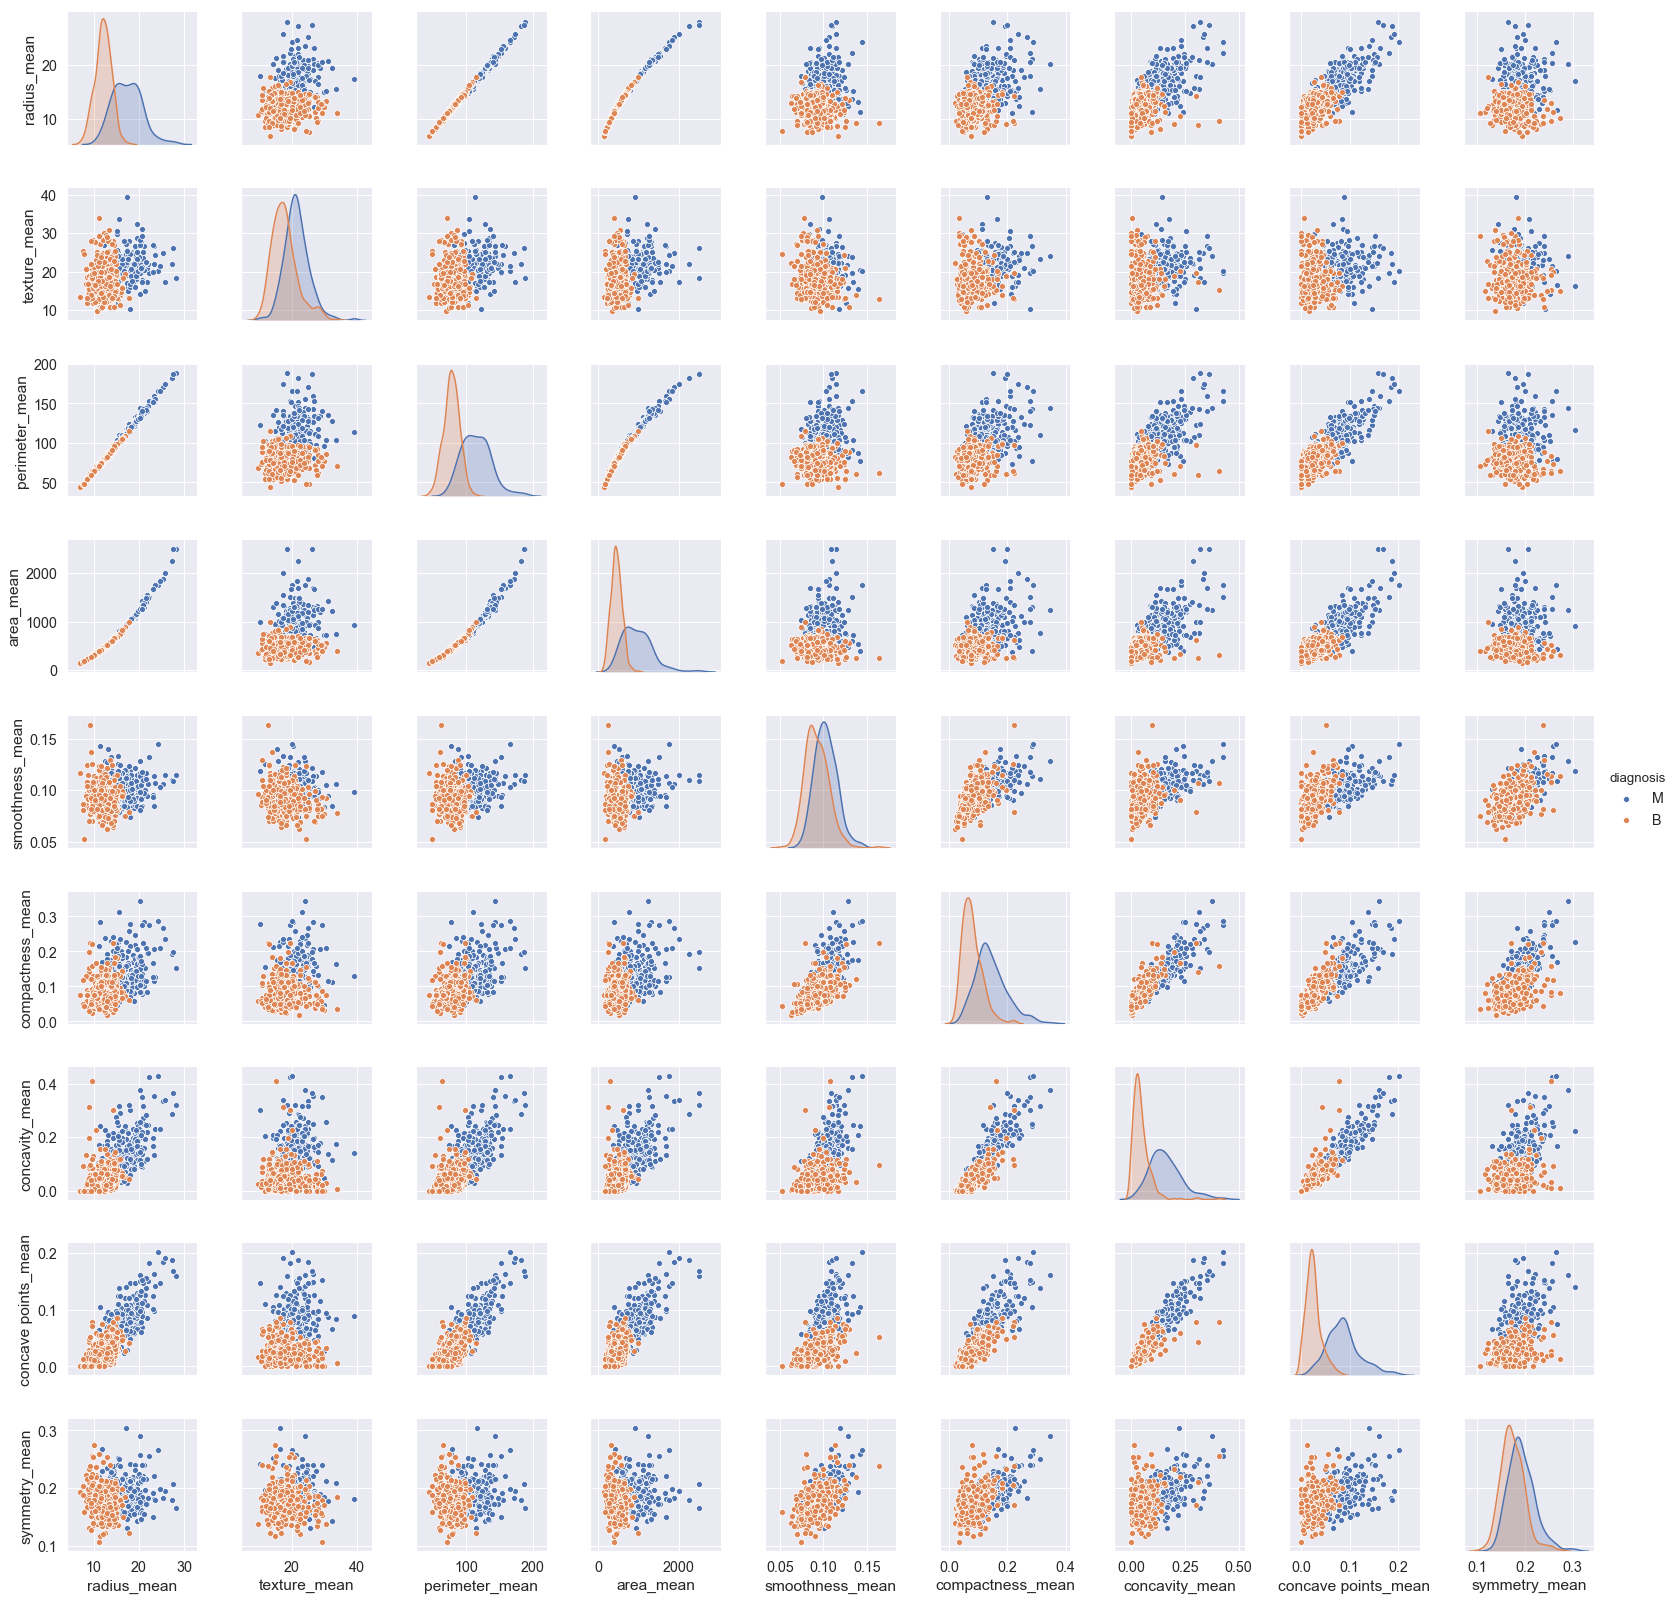

In [6]:
#let's see what interesting findings we can have by just plot them all
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3) #set font scale so it is more readable
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.3)
sns.pairplot(data=data.iloc[:,:10],hue='diagnosis')

#in most of the plots, we can see a very clear seperation between the diagnosis

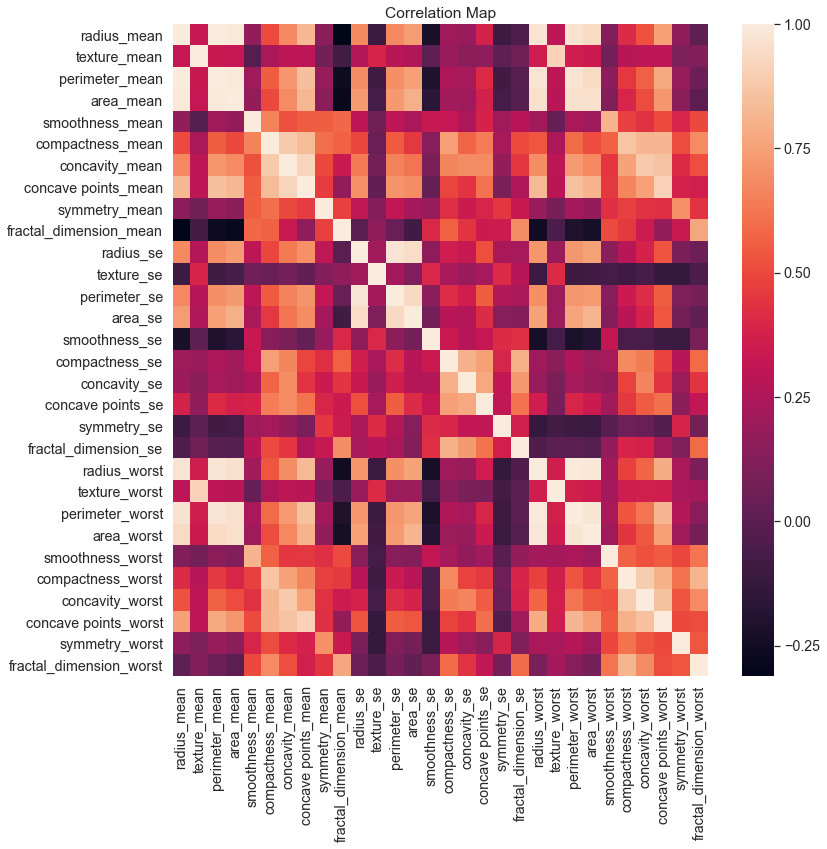

In [7]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3) #set font scale so it is more readable
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.3)
plt.title("Correlation Map")
sns.heatmap(data.corr())

In [8]:
data.corr() # a lot of highly correlatted features, we can aplly PCA to it

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


# Before PCA, normalization is needed for PCA to work correctly

In [9]:
data.drop('diagnosis',axis=1).values.mean(axis=0) #means

array([1.41272917e+01, 1.92896485e+01, 9.19690334e+01, 6.54889104e+02,
       9.63602812e-02, 1.04340984e-01, 8.87993158e-02, 4.89191459e-02,
       1.81161863e-01, 6.27976098e-02, 4.05172056e-01, 1.21685343e+00,
       2.86605923e+00, 4.03370791e+01, 7.04097891e-03, 2.54781388e-02,
       3.18937163e-02, 1.17961371e-02, 2.05422988e-02, 3.79490387e-03,
       1.62691898e+01, 2.56772232e+01, 1.07261213e+02, 8.80583128e+02,
       1.32368594e-01, 2.54265044e-01, 2.72188483e-01, 1.14606223e-01,
       2.90075571e-01, 8.39458172e-02])

In [10]:
data.drop('diagnosis',axis=1).values.std(axis=0) #standard deviation

array([3.52095076e+00, 4.29725464e+00, 2.42776193e+01, 3.51604754e+02,
       1.40517641e-02, 5.27663291e-02, 7.96497253e-02, 3.87687325e-02,
       2.73901809e-02, 7.05415588e-03, 2.77068942e-01, 5.51163427e-01,
       2.02007710e+00, 4.54510134e+01, 2.99987837e-03, 1.78924359e-02,
       3.01595231e-02, 6.16486075e-03, 8.25910439e-03, 2.64374475e-03,
       4.82899258e+00, 6.14085432e+00, 3.35730016e+01, 5.68856459e+02,
       2.28123569e-02, 1.57198171e-01, 2.08440875e-01, 6.56745545e-02,
       6.18130785e-02, 1.80453893e-02])

In [11]:
scaler=StandardScaler()
scaler.fit(data.drop('diagnosis',axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
scaled_data=scaler.transform(data.drop('diagnosis',axis=1))
scaled_data[0:5]

array([[ 1.09706398e+00, -2.07333501e+00,  1.26993369e+00,
         9.84374905e-01,  1.56846633e+00,  3.28351467e+00,
         2.65287398e+00,  2.53247522e+00,  2.21751501e+00,
         2.25574689e+00,  2.48973393e+00, -5.65265059e-01,
         2.83303087e+00,  2.48757756e+00, -2.14001647e-01,
         1.31686157e+00,  7.24026158e-01,  6.60819941e-01,
         1.14875667e+00,  9.07083081e-01,  1.88668963e+00,
        -1.35929347e+00,  2.30360062e+00,  2.00123749e+00,
         1.30768627e+00,  2.61666502e+00,  2.10952635e+00,
         2.29607613e+00,  2.75062224e+00,  1.93701461e+00],
       [ 1.82982061e+00, -3.53632408e-01,  1.68595471e+00,
         1.90870825e+00, -8.26962447e-01, -4.87071673e-01,
        -2.38458552e-02,  5.48144156e-01,  1.39236330e-03,
        -8.68652457e-01,  4.99254601e-01, -8.76243603e-01,
         2.63326966e-01,  7.42401948e-01, -6.05350847e-01,
        -6.92926270e-01, -4.40780058e-01,  2.60162067e-01,
        -8.05450380e-01, -9.94437403e-02,  1.80592744e+

In [13]:
scaled_data.mean(axis=0) #in same scale

array([-1.37363271e-16,  6.86816353e-17, -1.24875700e-16, -2.18532476e-16,
        1.74825981e-16,  1.99801121e-16,  3.74627101e-17, -3.74627101e-17,
        1.87313551e-16,  4.52674414e-16,  2.49751401e-16, -1.03022453e-16,
       -3.49651961e-16, -1.31119486e-16,  4.40186844e-16,  1.81069766e-16,
        1.62338411e-16,  1.24875700e-17,  8.11692053e-17,  6.24378502e-18,
       -8.24179623e-16,  1.24875700e-17, -3.74627101e-16,  0.00000000e+00,
       -2.37263831e-16, -3.37164391e-16,  7.49254203e-17,  2.24776261e-16,
        2.74726541e-16,  2.12288691e-16])

In [14]:
scaled_data.std(axis=0) #same std

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# PCA

n_components= 1 
variance ratio 44.27202560752644
n_components= 2 
variance ratio 63.243207651559466
n_components= 3 
variance ratio 72.63637090893354
n_components= 4 
variance ratio 79.23850582442765
n_components= 5 
variance ratio 84.73427431676413
n_components= 6 
variance ratio 88.75879635667734
n_components= 7 
variance ratio 91.0095300695928
n_components= 8 
variance ratio 92.59825386844133
n_components= 9 
variance ratio 93.98790324398428
n_components= 10 
variance ratio 95.15688143308137
n_components= 11 
variance ratio 96.13660041757409
n_components= 12 
variance ratio 97.00713832195899
n_components= 13 
variance ratio 97.8116633090766
n_components= 14 
variance ratio 98.33502905268908


Text(0, 0.5, 'explained_variance')

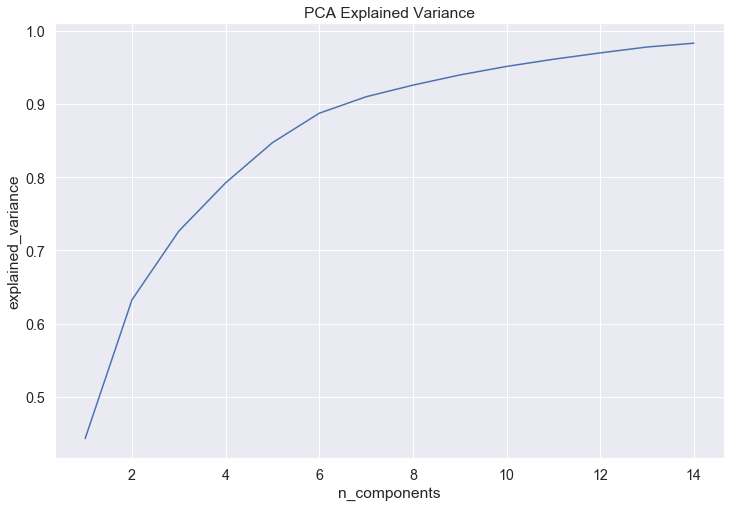

In [15]:
explained_variance=[]
for i in range(1,15):
    pca=PCA(n_components=i)
    pca.fit(scaled_data)
    explained_variance.append(pca.explained_variance_ratio_.sum())
    print('n_components=',i,'\nvariance ratio',pca.explained_variance_ratio_.sum()*100)

sns.lineplot(x=np.arange(1,15),y=explained_variance)
plt.title("PCA Explained Variance")
plt.xlabel("n_components")
plt.ylabel("explained_variance")

### so with 10 component, it can explain more than 95% of  the data
### let's use PCA as a method to detecting outliers by setting n_components=2

In [16]:
pca=PCA(n_components=2)
pca.fit(scaled_data)
outlier_detaction=pca.transform(scaled_data)
df_out=pd.DataFrame(outlier_detaction)
df_out['diag']=data['diagnosis']

Text(0.5, 1.0, 'Outlier Detectaion')

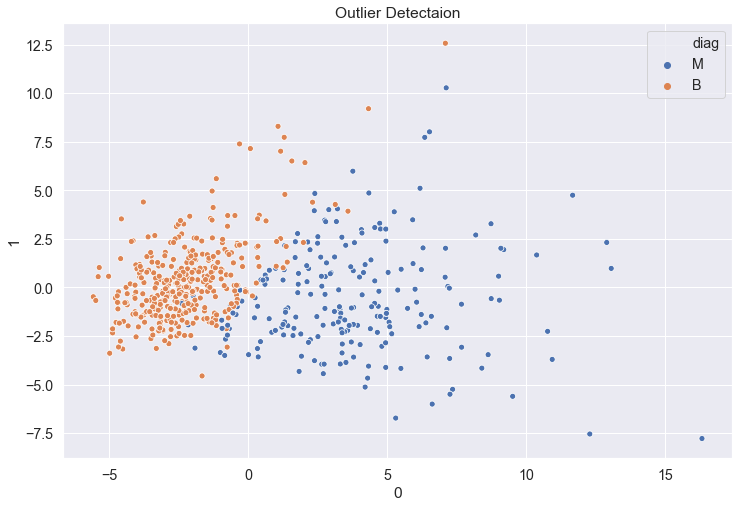

In [17]:
sns.scatterplot(x=0,y=1,hue='diag',data=df_out)
plt.title("Outlier Detectaion")

### Can't see any strong outliers that have huge impact on PCA, let's proceed with the PCA.

In [18]:
data['diag']=np.where(data['diagnosis']=='M', 1, 0) #encode 'M' to be 1 and 'B' to be 0

In [19]:
#10 components for 95% explained variance
pca=PCA(n_components=10)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)

In [20]:
def biplot(score,coeff,pcax,pcay,labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5) 
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.title('PCA Biplot')
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

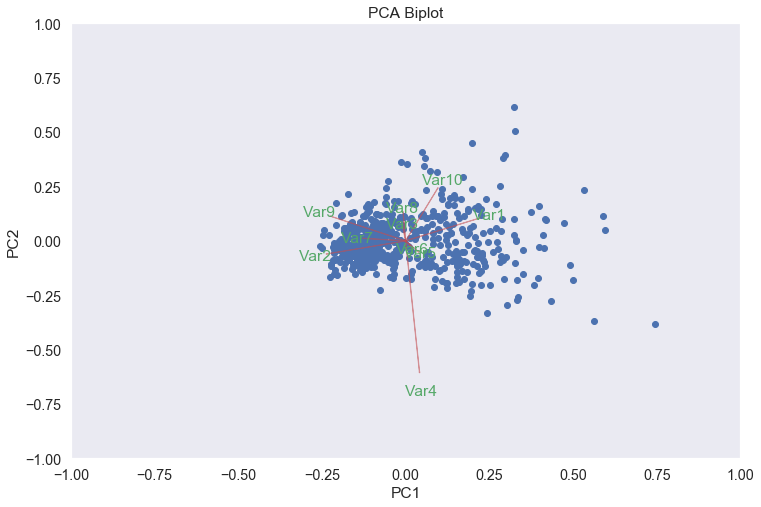

In [119]:
biplot(x_pca,pca.components_,1,2,)

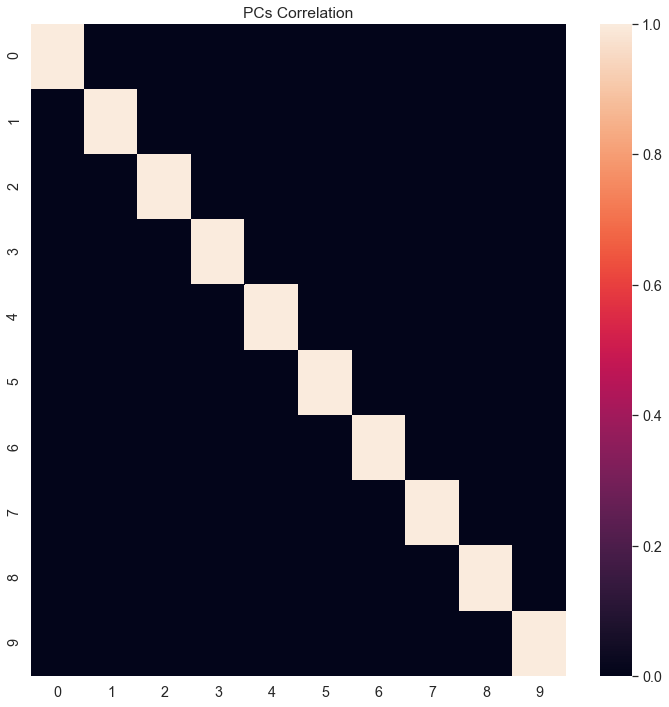

In [22]:
#check for feature correlation one more time just to make sure they are not correlated
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3) #set font scale so it is more readable
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.3)
plt.title("PCs Correlation")
sns.heatmap(pd.DataFrame(x_pca).corr())
#all are uncorrelated

## Model Preparing
## As for the fine tuning part, bias variance trade off along with mean recall score and recall std. across 10 fold cross validation was choce. The bias variance trade off ensure the model trained is neither underfitting nor overfitting. The mean recall to measure performance of the model so that minimum false negative can be reached. One more thing is that the smaller std is, the more stable the model will perform, so that when a unseen dataset is put into the model, we know that the model will have a reliable performance.

In [23]:
x=pd.DataFrame(data=x_pca)

In [24]:
y=data['diag']
X_train, X_test, y_train , y_test=train_test_split(x,y, test_size=0.2, stratify=y, random_state=42)
#X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

In [25]:
#set up cross validation

def run_kfold(model):
    
    
    model.fit(X_train,y_train)
    outcomes=cross_val_score(model,X_train,y_train,cv=10,scoring='recall') 
    #use recall score to measure the performance of the model 
    #so that we can minimize the FN which a Malignant case is wrongly diagnosed as Benign
    
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean recall score: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 
    
    print(outcomes)
    sns.lineplot(y=outcomes*100,x=range(10))
    plt.xlim(0,10)
    plt.ylim(0,100)

    plt.legend(['Average Recall Score'])
    plt.title("Cross validation Score")
    plt.xlabel("Folds")
    plt.ylabel("Recall score")

In [26]:
#define a bias function to calculate the bias
def bias(y_test,y_predict):
    bia = np.mean((y_test-y_predict)**2)
    return bia

In [27]:
#create a df to store all model training scores
model_score=pd.DataFrame()

# I have misunderstood the meaning of presentation GUIDELINES and thought I need to use all the method mentioned in the guideline. After presentation, especially after seeing what the other classmates have done, I realized how wrong I was. Hence, I have comment out all the regression model since it is a classification problem. 
### Along with all that, I wrongly judged who the audience would be, I thought the presentation was meant to be for someone like my wife, who has no background at all, neither in statistics nor in machine learning, so I have put things very simple. It is all my fault, I should have ask before I jump to that judgement.


## L2 Ridge Regression

In [28]:
# #fit a default parameter setting
# l2=Ridge()
# l2.fit(X_train, y_train)
# pred_l2=l2.predict(X_train)
# r2_score(y_train,pred_l2)

In [29]:
# ridge_alpha=[50,100,300,500,800,1000,2000,4000,6000,8000,10000,30000,60000,100000]
# ridge_bias=[]
# ridge_variance=[]
# ridge_total=[]
# for al in ridge_alpha:
#     model_ridge=Ridge(alpha=al, random_state=42)
#     model_ridge.fit(X_train,y_train)
#     pred=model_ridge.predict(X_train)
#     ridge_bias.append(bias(pred,y_train))
#     ridge_variance.append(np.var(pred))
#     ridge_total.append(bias(pred,y_train)+np.var(pred))


In [30]:
# sns.lineplot(x=ridge_alpha,y=ridge_bias)
# sns.lineplot(x=ridge_alpha,y=ridge_variance)
# sns.lineplot(x=ridge_alpha,y=ridge_total)
# plt.legend(['Bias','Variance','Total'])
# plt.title("L2 Bias-Variance Trade off")
# plt.xlabel("Alpha")
# plt.ylabel("Bias-Variance Trade off")

In [31]:
# ridge_alpha[ridge_total.index(min(ridge_total))] #return Alpha when the total error reach minimum 

In [32]:
# #fit the tuned parameter setting
# l2=Ridge(alpha=6000)
# l2.fit(X_train, y_train)
# pred_l2=l2.predict(X_train)
# r2_score(y_train,pred_l2)

In [33]:
# ridge_importances=l2.coef_  # For lasso regression coefficients indicate the importance of the features
# ridge_importances

## L1 Lasso Regression

In [34]:
# #fit a default parameter setting
# l1=Lasso()
# l1.fit(X_train, y_train)
# pred_l1=l1.predict(X_train)
# r2_score(y_train,pred_l1)

In [35]:
# lasso_alpha=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,1.5,2,2.5,3,4,5,6]
# lasso_bias=[]
# lasso_variance=[]
# lasso_total=[]
# for al in lasso_alpha:
#     model_lasso=Lasso(alpha=al, random_state=42)
#     model_lasso.fit(X_train,y_train)
#     pred=model_lasso.predict(X_train)
#     lasso_bias.append(bias(pred,y_train))
#     lasso_variance.append(np.var(pred))
#     lasso_total.append(bias(pred,y_train)+np.var(pred))


In [36]:
# sns.lineplot(x=lasso_alpha,y=lasso_bias)
# sns.lineplot(x=lasso_alpha,y=lasso_variance)
# sns.lineplot(x=lasso_alpha,y=lasso_total)
# plt.legend(['Bias','Variance','Total'])
# plt.title("L1 Bias-Variance Trade off")
# plt.xlabel("alpha")
# plt.ylabel("Bias-Variance Trade off")

In [37]:
# lasso_alpha[lasso_total.index(min(lasso_total))] #return Alpha when the total error reach minimum 

In [38]:
# #fit the tuned parameter setting
# l1=Lasso(alpha=0.7)
# l1.fit(X_train, y_train)
# pred_l1=l1.predict(X_train)
# r2_score(y_train,pred_l1)

In [39]:
# laso_importances=l1.coef_  # For lasso regression coefficients indicate the importance of the features
# laso_importances

In [40]:
# sns.lineplot(x=np.arange(1,11),y=laso_importances)
# sns.lineplot(x=np.arange(1,11),y=ridge_importances)
# plt.legend(['Lasso','Ridge'])
# plt.title("Feature Importance")
# plt.xlabel("PCs")
# plt.ylabel("Coefficients")

# Random Forest & Its Tuning

In [41]:
#fit a default Random Forest parameter setting
rfc=RandomForestClassifier(criterion='gini', max_depth=10,n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Mean recall score: 0.9352941176470588
Standard Deviation: 0.061413567699473835
[0.88235294 0.88235294 1.         1.         0.82352941 0.94117647
 1.         0.94117647 0.88235294 1.        ]


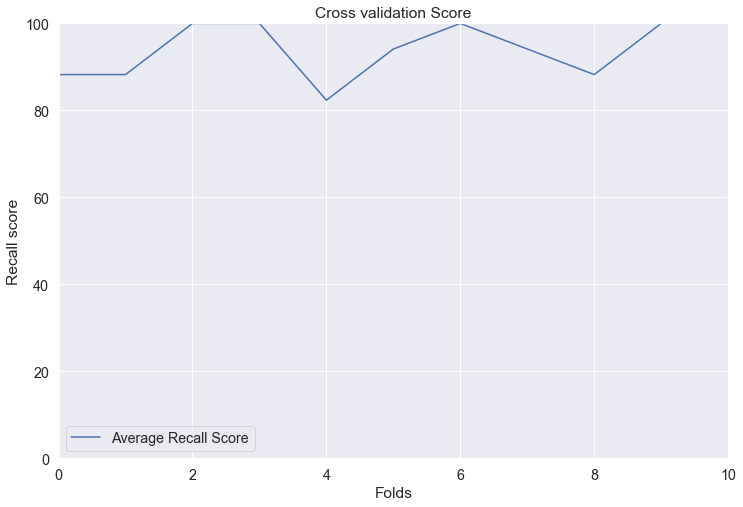

In [42]:
run_kfold(rfc)

In [43]:
#tune the estimators
rf_estimators=[1, 2, 4, 8, 16, 32, 40, 48, 64, 80, 96, 100, 150]
rf_bias_n=[]
rf_variance_n=[]
rf_total_n=[]
rf_mean_recall=[]
rf_std_recall=[]
  
for estimator in rf_estimators:
    model_rf=RandomForestClassifier(criterion='gini', max_depth=10,n_estimators=estimator, random_state=42)
    model_rf.fit(X_train,y_train)
    outcomes=cross_val_score(model_rf,X_train,y_train,cv=10,scoring='recall')
    rf_mean_recall.append(np.mean(outcomes))
    rf_std_recall.append(np.std(outcomes)) 
    pred=model_rf.predict(X_train)
    rf_bias_n.append(bias(pred,y_train))
    rf_variance_n.append(np.var(pred))
    rf_total_n.append(bias(pred,y_train)+np.var(pred))


Text(0, 0.5, 'Bias-Variance Trade off')

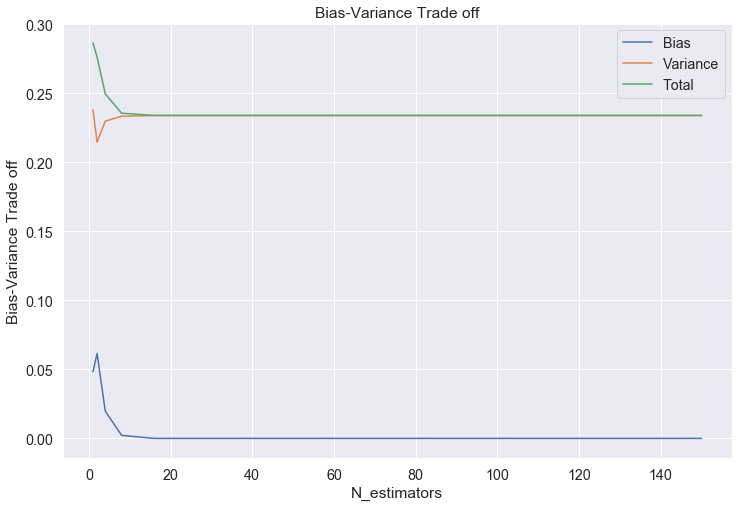

In [44]:
sns.lineplot(x=rf_estimators,y=rf_bias_n)
sns.lineplot(x=rf_estimators,y=rf_variance_n)
sns.lineplot(x=rf_estimators,y=rf_total_n)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("N_estimators")
plt.ylabel("Bias-Variance Trade off")

Text(0, 0.5, 'Recall Scores')

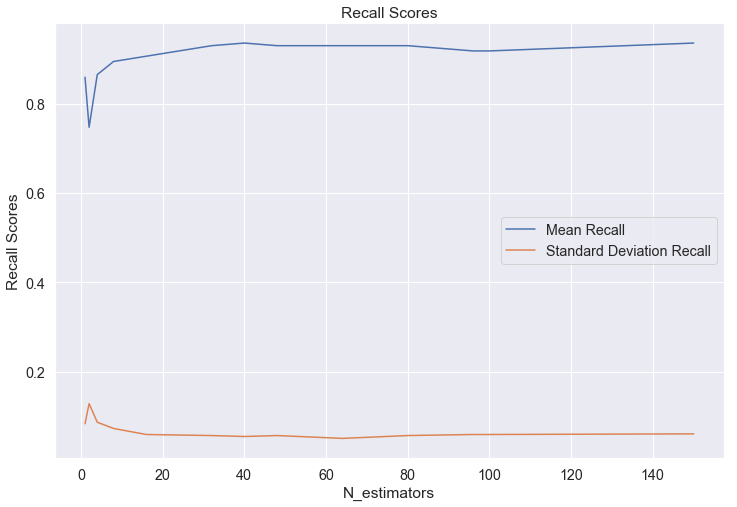

In [45]:
sns.lineplot(x=rf_estimators,y=rf_mean_recall)
sns.lineplot(x=rf_estimators,y=rf_std_recall)

plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("N_estimators")
plt.ylabel("Recall Scores")

In [46]:
rf_estimators[rf_total_n.index(min(rf_total_n))] #the value that results in minimum total error

16

In [47]:
rf_estimators[rf_mean_recall.index(max(rf_mean_recall))] #the value that results in maximum mean recall score

40

In [48]:
rf_estimators[rf_std_recall.index(min(rf_std_recall))] #the value that results in minimum recall std. 

64

## n_estimators=64 was chose because after 16, the total error stays about the same and recall mean stays about the same after 40. 

In [49]:
rf_max_depths = np.linspace(1, 32, 32, endpoint=True)
rf_bias_d=[]
rf_variance_d=[]
rf_total_d=[]
rf_mean_recall=[]
rf_std_recall=[]

for depth in rf_max_depths:
    model_rf=RandomForestClassifier(criterion='gini', max_depth=depth,n_estimators=40, random_state=42)
    model_rf.fit(X_train,y_train)
    outcomes=cross_val_score(model_rf,X_train,y_train,cv=10,scoring='recall')
    rf_mean_recall.append(np.mean(outcomes))
    rf_std_recall.append(np.std(outcomes))     
    pred=model_rf.predict(X_train)
    rf_bias_d.append(bias(pred,y_train))
    rf_variance_d.append(np.var(pred))
    rf_total_d.append(bias(pred,y_train)+np.var(pred))

Text(0, 0.5, 'Bias-Variance Trade off')

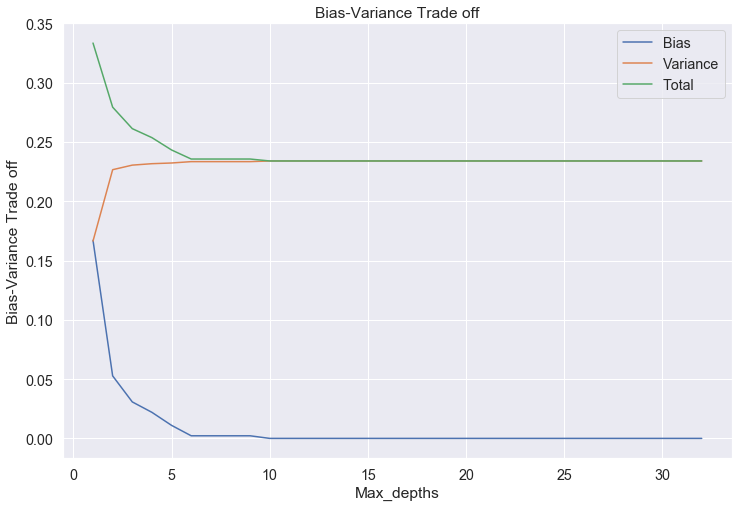

In [50]:
sns.lineplot(x=rf_max_depths,y=rf_bias_d)
sns.lineplot(x=rf_max_depths,y=rf_variance_d)
sns.lineplot(x=rf_max_depths,y=rf_total_d)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Max_depths")
plt.ylabel("Bias-Variance Trade off")

Text(0, 0.5, 'Recall Scores')

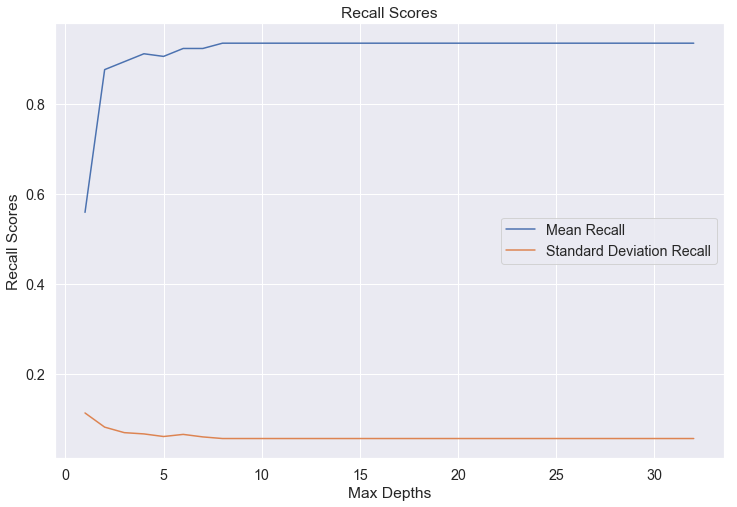

In [51]:
sns.lineplot(x=rf_max_depths,y=rf_mean_recall)
sns.lineplot(x=rf_max_depths,y=rf_std_recall)

plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("Max Depths")
plt.ylabel("Recall Scores")

In [52]:
rf_max_depths[rf_total_d.index(min(rf_total_d))] #the value that results in minimum total error

10.0

In [53]:
rf_max_depths[rf_mean_recall.index(max(rf_mean_recall))] #the value that results in maximum mean recall

8.0

In [54]:
rf_max_depths[rf_std_recall.index(min(rf_std_recall))] #the value that results in minimum recall std

8.0

## max_depth=10 was chose as the mean recall and recall std stays about the same after 8

Mean recall score: 0.9294117647058824
Standard Deviation: 0.051281164041654996
[0.88235294 0.88235294 1.         1.         0.88235294 0.94117647
 1.         0.88235294 0.88235294 0.94117647]


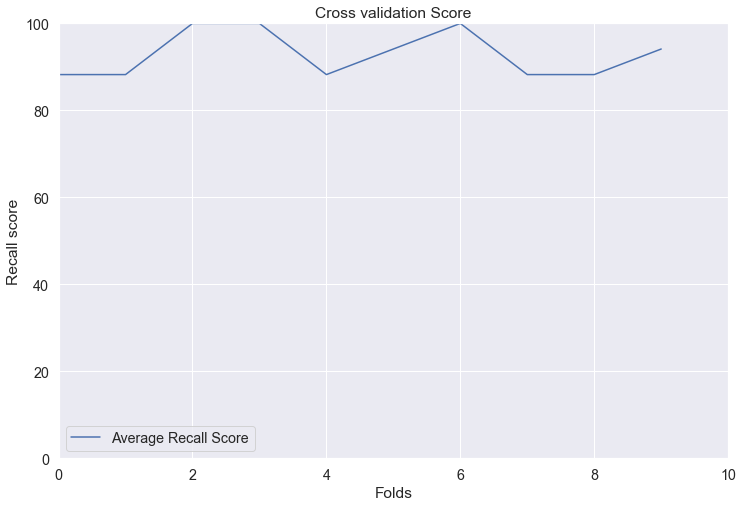

In [55]:
rfc_tuned=RandomForestClassifier(criterion='gini', max_depth=10,n_estimators=64, random_state=42)
run_kfold(rfc_tuned)

In [56]:
#store training score
outcomes=cross_val_score(rfc_tuned,X_train,y_train,cv=10,scoring='recall')
model_score['Random Forest']=[np.mean(outcomes),np.std(outcomes)]
model_score.index=['Recall Mean','Recall Std.']

## XGBoost & Its Tuning

Mean recall score: 0.9470588235294117
Standard Deviation: 0.061413567699473835
[1.         0.82352941 1.         1.         0.94117647 0.88235294
 1.         0.94117647 0.88235294 1.        ]


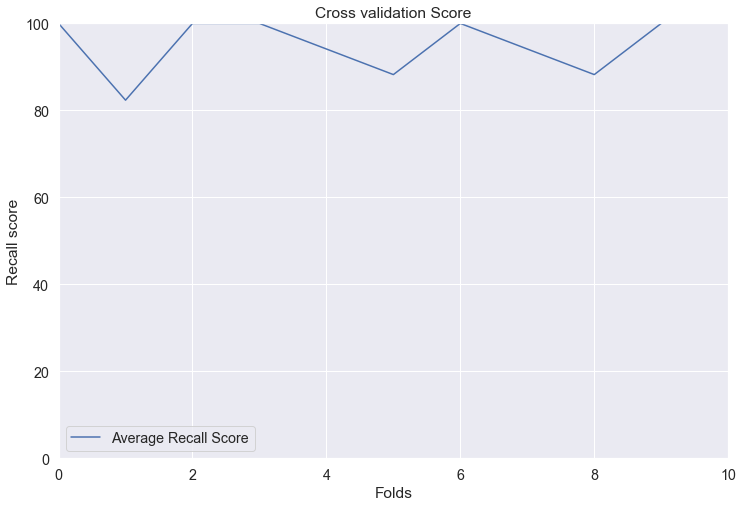

In [57]:
xgb=XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100) #defaut parameter value
xgb.fit(X_train, y_train)
run_kfold(xgb)

In [58]:
xgb_estimators=[1, 2, 4, 8, 16, 32, 40, 48, 64, 80, 96, 100, 150]
xgb_bias_n=[]
xgb_variance_n=[]
xgb_total_n=[]
xgb_mean_recall=[]
xgb_std_recall=[]
  
for estimator in xgb_estimators:
    model_xgb=XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=estimator,random_state=42)
    model_xgb.fit(X_train,y_train)
    outcomes=cross_val_score(model_xgb,X_train,y_train,cv=10,scoring='recall')
    xgb_mean_recall.append(np.mean(outcomes))
    xgb_std_recall.append(np.std(outcomes)) 
    pred=model_xgb.predict(X_train)
    xgb_bias_n.append(bias(pred,y_train))
    xgb_variance_n.append(np.var(pred))
    xgb_total_n.append(bias(pred,y_train)+np.var(pred))


Text(0, 0.5, 'Bias-Variance Trade off')

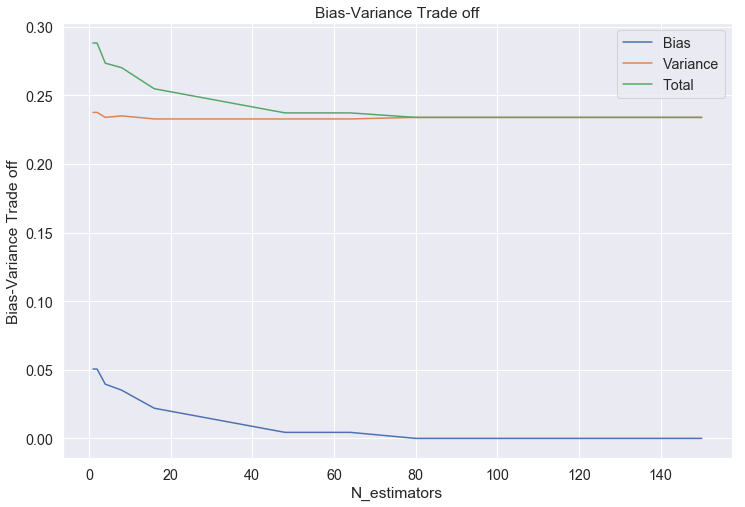

In [59]:
sns.lineplot(x=xgb_estimators,y=xgb_bias_n)
sns.lineplot(x=xgb_estimators,y=xgb_variance_n)
sns.lineplot(x=xgb_estimators,y=xgb_total_n)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("N_estimators")
plt.ylabel("Bias-Variance Trade off")

Text(0, 0.5, 'Recall Scores')

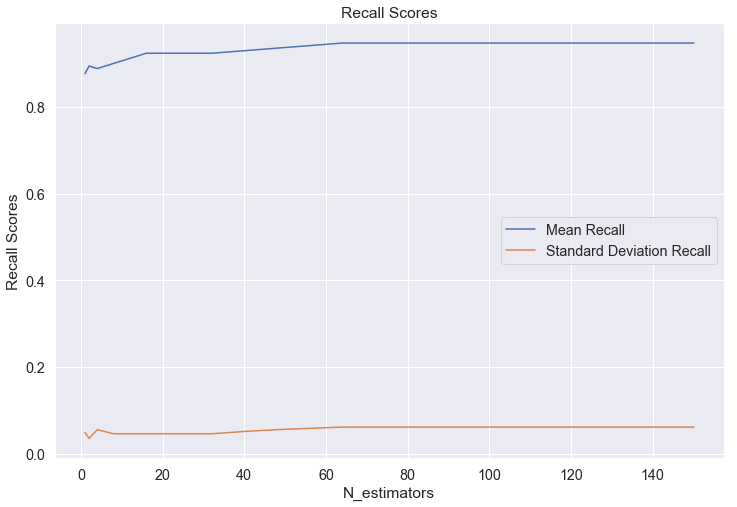

In [60]:
sns.lineplot(x=xgb_estimators,y=xgb_mean_recall)
sns.lineplot(x=xgb_estimators,y=xgb_std_recall)

plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("N_estimators")
plt.ylabel("Recall Scores")

In [61]:
xgb_estimators[xgb_total_n.index(min(xgb_total_n))] #the value that results in minimum total error

80

In [62]:
xgb_estimators[xgb_mean_recall.index(max(xgb_mean_recall))] #the value that results in maximum 

64

In [63]:
xgb_estimators[xgb_std_recall.index(min(xgb_std_recall))] #the value that results in minimum 

2

## n_estimator=80 was chose as the recall parameters, even thought recall std increase a bit, are within small range compared to their optimal value

In [64]:
xgb_max_depths = np.arange(1,32)
xgb_bias_d=[]
xgb_variance_d=[]
xgb_total_d=[]
xgb_mean_recall=[]
xgb_std_recall=[]

for depth in xgb_max_depths:
    model_xgb=XGBClassifier(max_depth=depth,learning_rate=0.1,n_estimators=80,random_state=42)
    model_xgb.fit(X_train,y_train)
    outcomes=cross_val_score(model_xgb,X_train,y_train,cv=10,scoring='recall')
    xgb_mean_recall.append(np.mean(outcomes))
    xgb_std_recall.append(np.std(outcomes))     
    pred=model_xgb.predict(X_train)
    xgb_bias_d.append(bias(pred,y_train))
    xgb_variance_d.append(np.var(pred))
    xgb_total_d.append(bias(pred,y_train)+np.var(pred))

Text(0, 0.5, 'Bias-Variance Trade off')

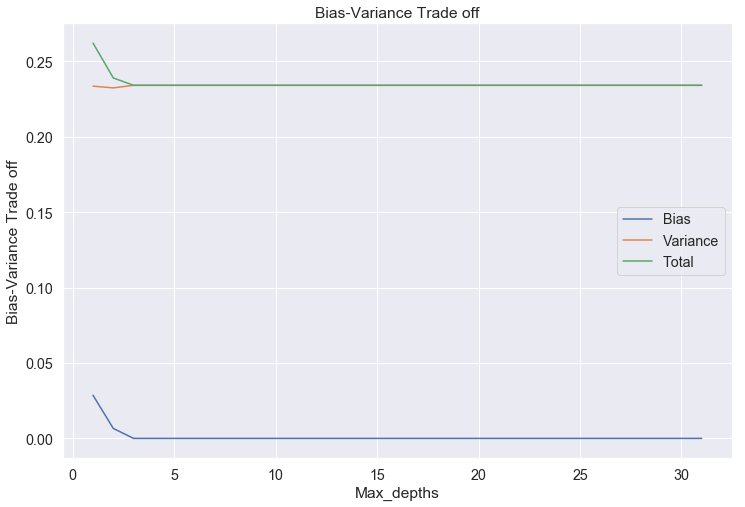

In [65]:
sns.lineplot(x=xgb_max_depths,y=xgb_bias_d)
sns.lineplot(x=xgb_max_depths,y=xgb_variance_d)
sns.lineplot(x=xgb_max_depths,y=xgb_total_d)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Max_depths")
plt.ylabel("Bias-Variance Trade off")

Text(0, 0.5, 'Recall Scores')

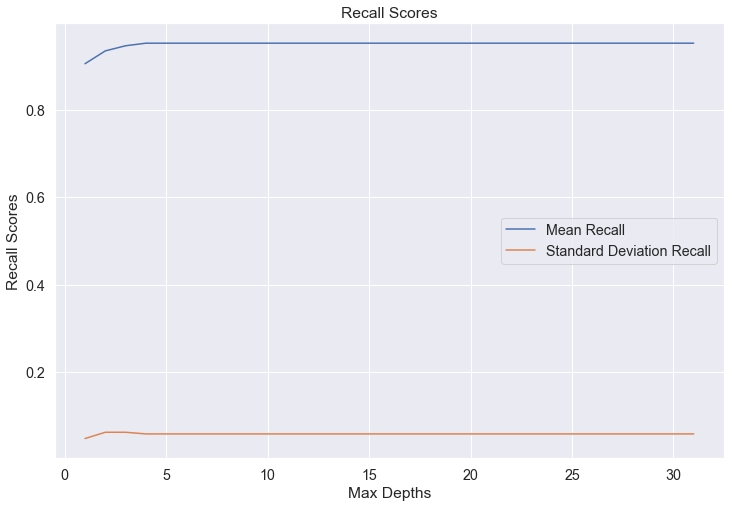

In [66]:
sns.lineplot(x=xgb_max_depths,y=xgb_mean_recall)
sns.lineplot(x=xgb_max_depths,y=xgb_std_recall)

plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("Max Depths")
plt.ylabel("Recall Scores")

In [67]:
xgb_max_depths[xgb_total_d.index(min(xgb_total_d))] #the value that results in minimum total error

3

In [68]:
xgb_max_depths[xgb_mean_recall.index(max(xgb_mean_recall))] #the value that results in maximum 

4

In [69]:
xgb_max_depths[xgb_std_recall.index(min(xgb_std_recall))] #the value that results in minimum 

1

## max_depth=4 was chose as the other parameter stays about the same comparing to their optimal value

In [70]:
xgb_learning_rate=[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,0.8,1,1.2,1.4]
xgb_bias_r=[]
xgb_variance_r=[]
xgb_total_r=[]
xgb_mean_recall=[]
xgb_std_recall=[]

for rate in xgb_learning_rate:
    model_xgb=XGBClassifier(max_depth=4,learning_rate=rate,n_estimators=80,random_state=42)
    model_xgb.fit(X_train,y_train)
    outcomes=cross_val_score(model_xgb,X_train,y_train,cv=10,scoring='recall')
    xgb_mean_recall.append(np.mean(outcomes))
    xgb_std_recall.append(np.std(outcomes))     
    pred=model_xgb.predict(X_train)
    xgb_bias_r.append(bias(pred,y_train))
    xgb_variance_r.append(np.var(pred))
    xgb_total_r.append(bias(pred,y_train)+np.var(pred))

Text(0, 0.5, 'Bias-Variance Trade off')

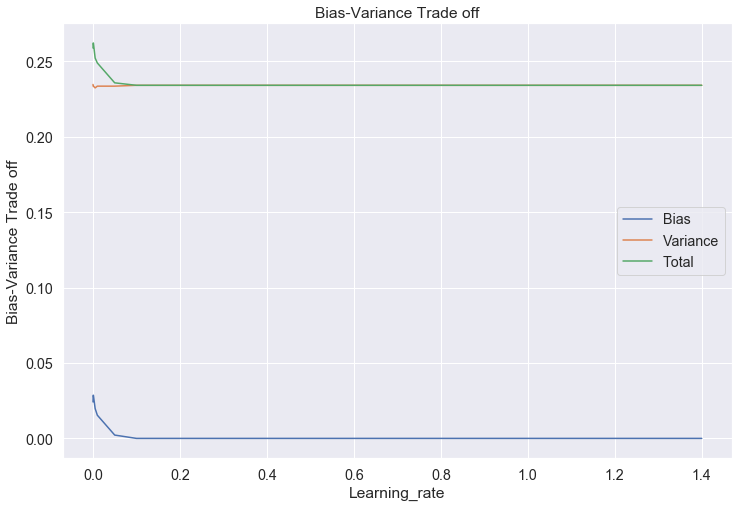

In [71]:
sns.lineplot(x=xgb_learning_rate,y=xgb_bias_r)
sns.lineplot(x=xgb_learning_rate,y=xgb_variance_r)
sns.lineplot(x=xgb_learning_rate,y=xgb_total_r)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Learning_rate")
plt.ylabel("Bias-Variance Trade off")

Text(0, 0.5, 'Recall Scores')

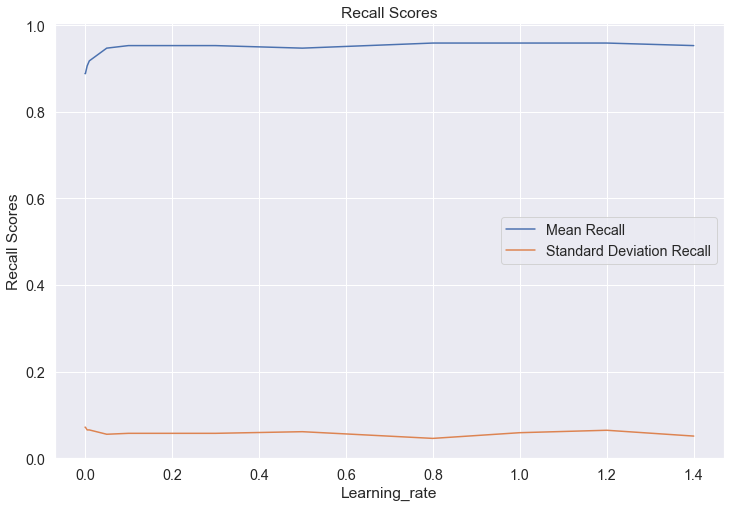

In [72]:
sns.lineplot(x=xgb_learning_rate,y=xgb_mean_recall)
sns.lineplot(x=xgb_learning_rate,y=xgb_std_recall)

plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("Learning_rate")
plt.ylabel("Recall Scores")

In [73]:
xgb_learning_rate[xgb_total_r.index(min(xgb_total_r))] #the value that results in minimum total error

0.1

In [74]:
xgb_learning_rate[xgb_mean_recall.index(max(xgb_mean_recall))] #the value that results in maximum 

0.8

In [75]:
xgb_learning_rate[xgb_std_recall.index(min(xgb_std_recall))] #the value that results in minimum 

0.8

## learning_rate=0.8 was chose as total error stays about the same after 0.1

Mean recall score: 0.9588235294117646
Standard Deviation: 0.045942645152392096
[1.         0.88235294 1.         1.         0.88235294 0.94117647
 1.         0.94117647 0.94117647 1.        ]


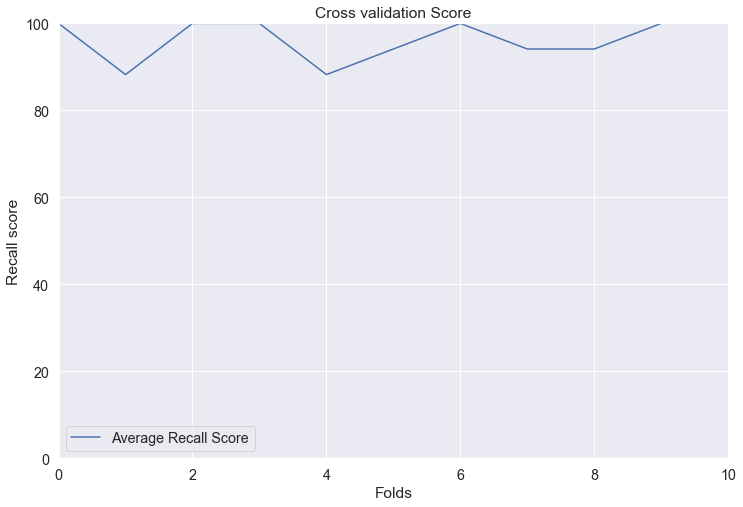

In [76]:
xgb_tuned=XGBClassifier(max_depth=4,learning_rate=0.8,n_estimators=80,random_state=42)
run_kfold(xgb_tuned)

In [77]:
#store training score
outcomes=cross_val_score(xgb_tuned,X_train,y_train,cv=10,scoring='recall')
model_score['XGBoost']=[np.mean(outcomes),np.std(outcomes)]

## KNN & Its Tuning

Mean recall score: 0.9235294117647058
Standard Deviation: 0.06984907110022306
[1.         0.82352941 1.         1.         0.82352941 0.88235294
 1.         0.88235294 0.88235294 0.94117647]


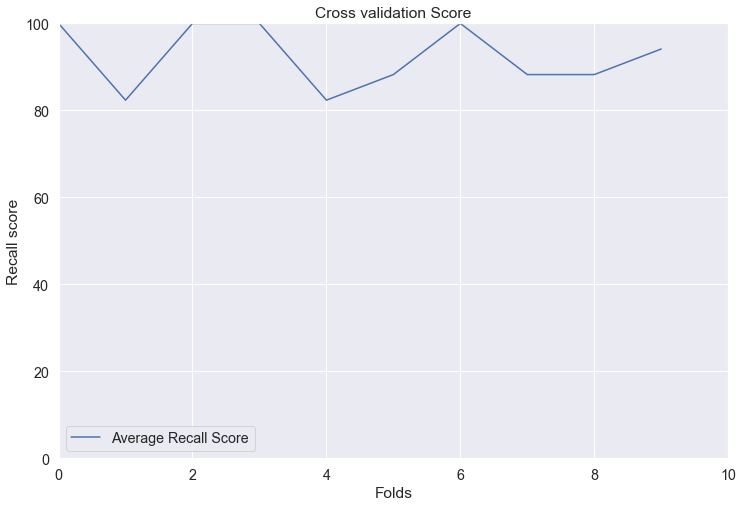

In [78]:
knn=KNeighborsClassifier()
knn.fit(X_train, y_train)
run_kfold(knn)

In [79]:
neighbors = np.arange(1,100)
knn_bias_n=[]
knn_variance_n=[]
knn_total_n=[]
knn_mean_recall=[]
knn_std_recall=[]

for n in neighbors:
    model_knn=KNeighborsClassifier(n_neighbors=n)
    model_knn.fit(X_train,y_train)
    outcomes=cross_val_score(model_knn,X_train,y_train,cv=10,scoring='recall')
    knn_mean_recall.append(np.mean(outcomes))
    knn_std_recall.append(np.std(outcomes))    
    pred=model_knn.predict(X_train)
    knn_bias_n.append(bias(pred,y_train))
    knn_variance_n.append(np.var(pred))
    knn_total_n.append(bias(pred,y_train)+np.var(pred))

Text(0, 0.5, 'Bias-Variance Trade off')

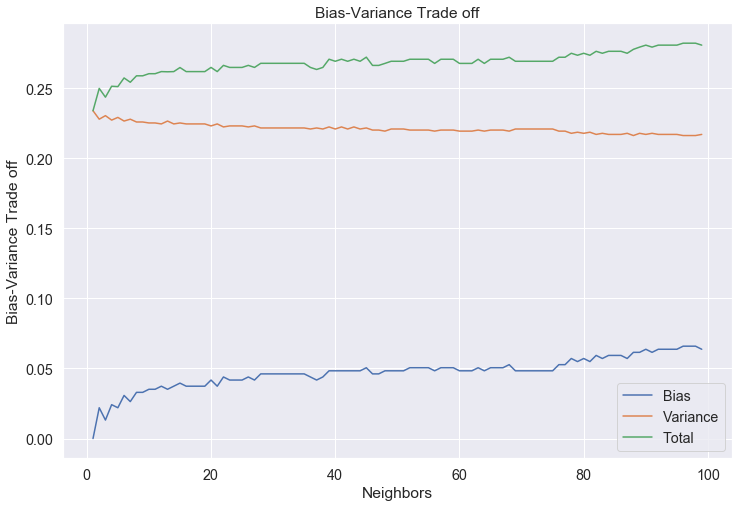

In [80]:
sns.lineplot(x=neighbors,y=knn_bias_n)
sns.lineplot(x=neighbors,y=knn_variance_n)
sns.lineplot(x=neighbors,y=knn_total_n)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Neighbors")
plt.ylabel("Bias-Variance Trade off")

Text(0, 0.5, 'Recall Scores')

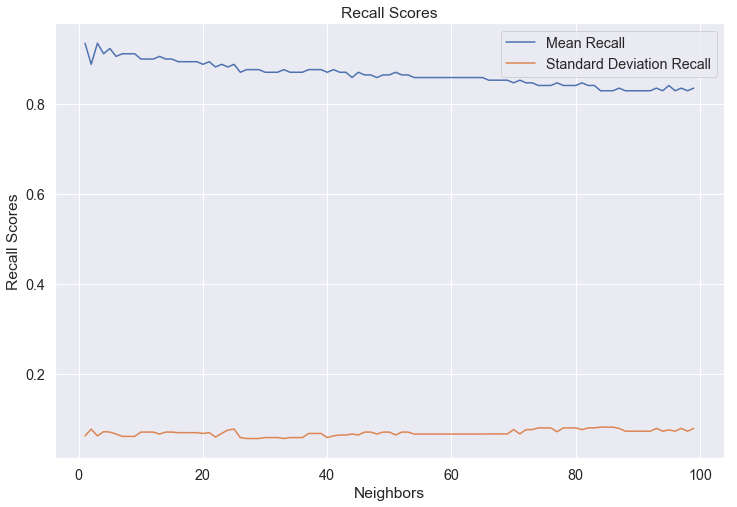

In [81]:
sns.lineplot(x=neighbors,y=knn_mean_recall)
sns.lineplot(x=neighbors,y=knn_std_recall)

plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("Neighbors")
plt.ylabel("Recall Scores")

In [82]:
neighbors[knn_total_n.index(min(knn_total_n[1:]))] #the value that results in minimum total error

3

In [83]:
neighbors[knn_mean_recall[1:].index(max(knn_mean_recall))+1] #the value that results in maximum recall

3

In [84]:
neighbors[knn_std_recall.index(min(knn_std_recall))] #the value that results in minimum recall std

27

## n_neighbors=3 was chose as the recall std varies a lot in a small range and it looks like with 3 neighbors, std can still strike good value

Mean recall score: 0.9352941176470588
Standard Deviation: 0.061413567699473835
[1.         0.94117647 1.         1.         0.82352941 0.88235294
 1.         0.88235294 0.88235294 0.94117647]


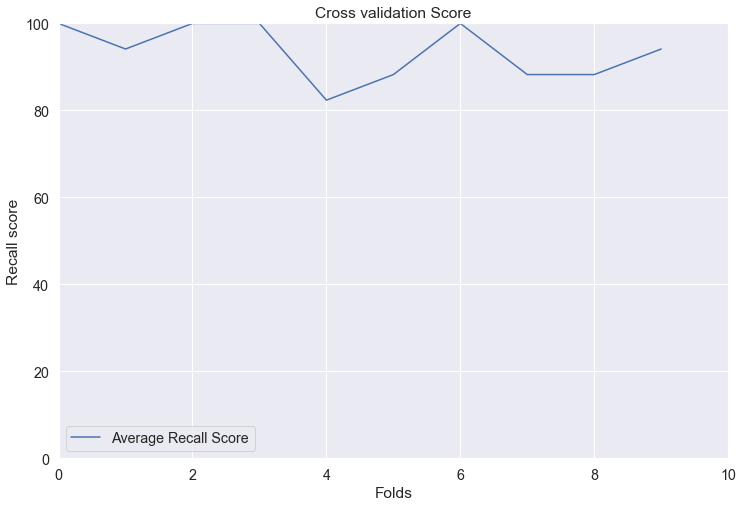

In [85]:
knn_tuned=KNeighborsClassifier(n_neighbors=3)
run_kfold(knn_tuned)

In [86]:
#store training score
outcomes=cross_val_score(knn_tuned,X_train,y_train,cv=10,scoring='recall')
model_score['KNN']=[np.mean(outcomes),np.std(outcomes)]

## Neural network & its tuning

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

Mean recall score: 0.9529411764705882
Standard Deviation: 0.05763505277136891
[1.         0.88235294 1.         1.         0.82352941 0.94117647
 0.94117647 1.         0.94117647 1.        ]


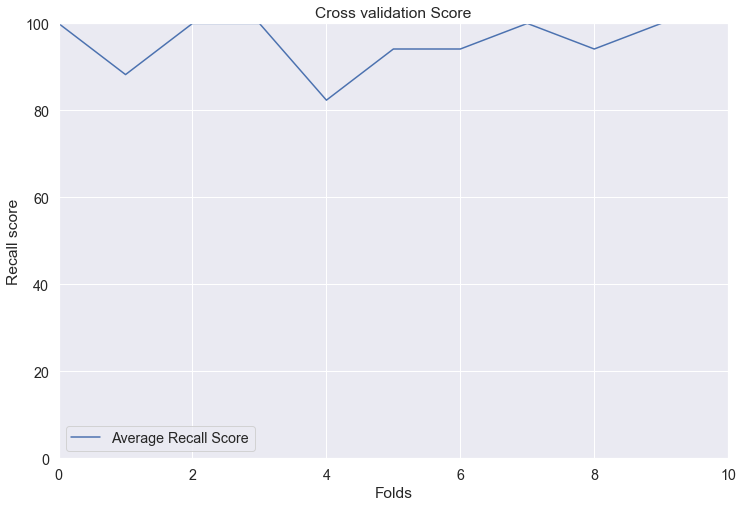

In [87]:
#set MLPClassifier with its default parameter values
nn=MLPClassifier(hidden_layer_sizes=(100, ),alpha=0.0001,max_iter=200)
nn.fit(X_train, y_train)
run_kfold(nn)

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

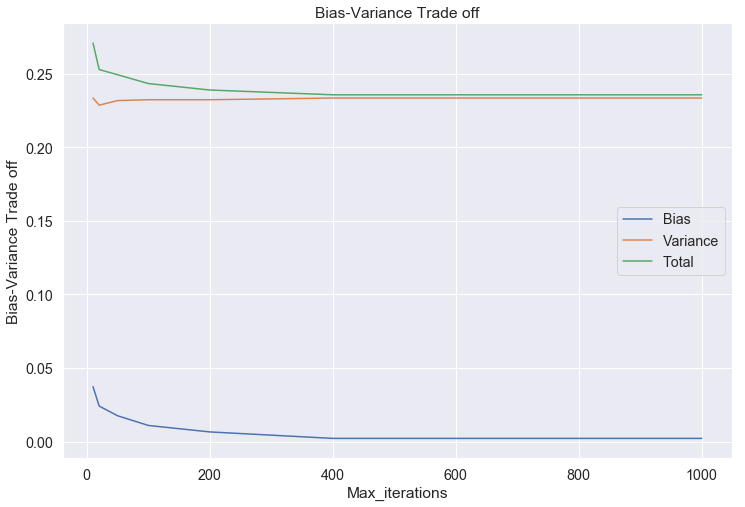

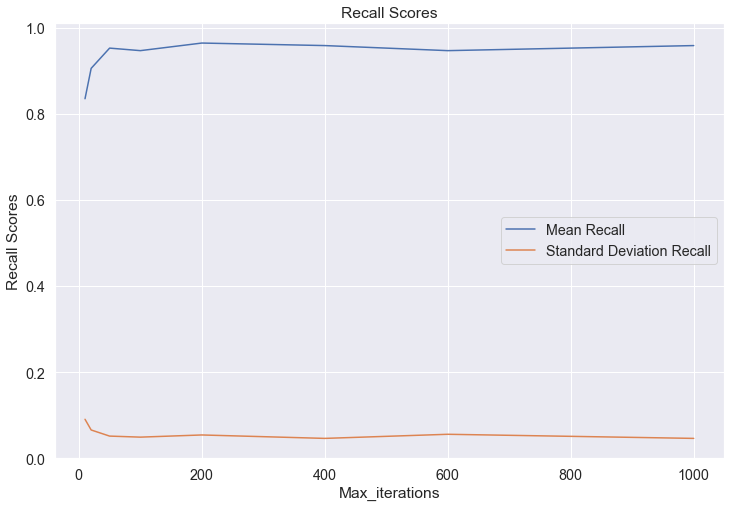

In [88]:
max_iterations=[10,20,50,100,200,400,600,1000] 
nn_bias=[]
nn_variance=[]
nn_total=[]
nn_mean_recall=[]
nn_std_recall=[]
 
for iterations in max_iterations:
    #set the layer to single layer and 100 nodes
    nn=MLPClassifier(hidden_layer_sizes=(100,),alpha=0.0001,max_iter=iterations)
    nn.fit(X_train, y_train)
    pred=nn.predict(X_train)
    outcomes=cross_val_score(nn,X_train,y_train,cv=10,scoring='recall')
    nn_mean_recall.append(np.mean(outcomes))
    nn_std_recall.append(np.std(outcomes))  
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))

bv=plt.figure(1)
sns.lineplot(x=max_iterations,y=nn_bias)
sns.lineplot(x=max_iterations,y=nn_variance)
sns.lineplot(x=max_iterations,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Max_iterations")
plt.ylabel("Bias-Variance Trade off")
bv.show()

rc=plt.figure(2)
sns.lineplot(x=max_iterations,y=nn_mean_recall)
sns.lineplot(x=max_iterations,y=nn_std_recall)
plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("Max_iterations")
plt.ylabel("Recall Scores")
rc.show()

In [89]:
max_iterations[nn_total.index(min(nn_total))] #the value that results in minimum total error

400

In [90]:
max_iterations[nn_mean_recall.index(max(nn_mean_recall))] #the value that results in maximum recall mean

200

In [91]:
max_iterations[nn_std_recall.index(min(nn_std_recall))] #the value that results in minimum recall std.

400

## 400 iterations can converg and reached minimum total error

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


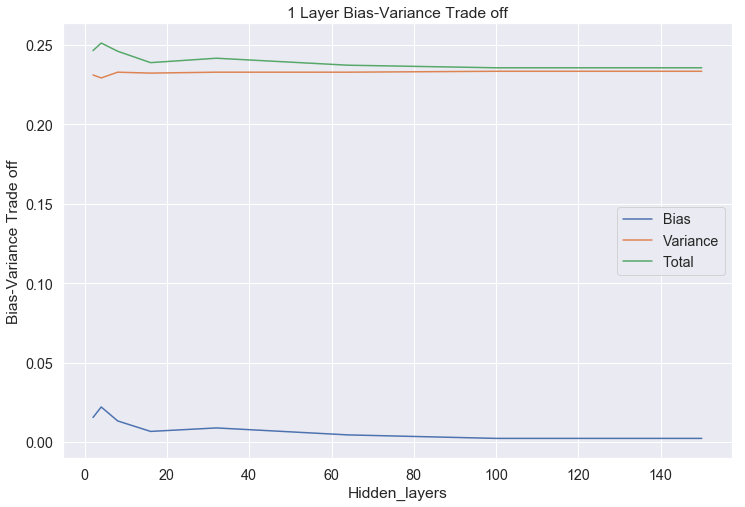

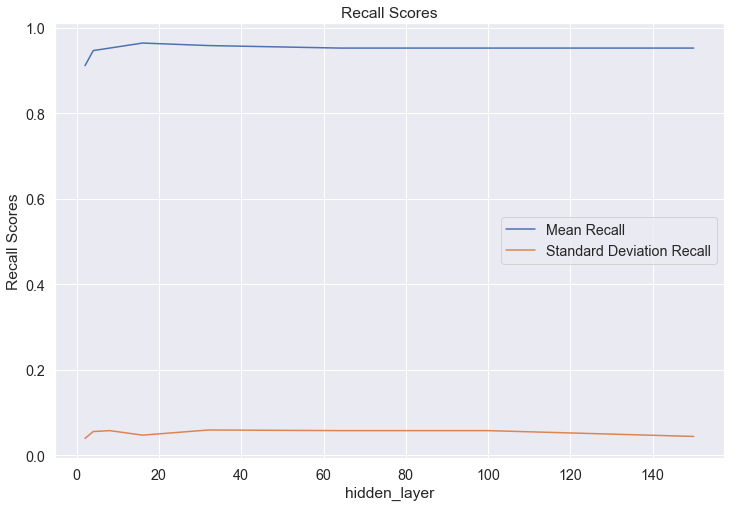

In [92]:
#now try 1 layers
hidden_layer=[2,4,8,16,32,64,100,150] 
nn_bias=[]
nn_variance=[]
nn_total=[]
nn_mean_recall=[]
nn_std_recall=[]

for layer in hidden_layer:
    nn=MLPClassifier(hidden_layer_sizes=(layer),alpha=0.0001,max_iter=400)
    nn.fit(X_train, y_train)
    pred=nn.predict(X_train)
    outcomes=cross_val_score(nn,X_train,y_train,cv=10,scoring='recall')
    nn_mean_recall.append(np.mean(outcomes))
    nn_std_recall.append(np.std(outcomes)) 
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))

bv=plt.figure(1)
sns.lineplot(x=hidden_layer,y=nn_bias)
sns.lineplot(x=hidden_layer,y=nn_variance)
sns.lineplot(x=hidden_layer,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("1 Layer Bias-Variance Trade off")
plt.xlabel("Hidden_layers")
plt.ylabel("Bias-Variance Trade off")
bv.show()

rc=plt.figure(2)
sns.lineplot(x=hidden_layer,y=nn_mean_recall)
sns.lineplot(x=hidden_layer,y=nn_std_recall)
plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("hidden_layer")
plt.ylabel("Recall Scores")
rc.show()

In [93]:
hidden_layer[nn_total.index(min(nn_total))] #the value that results in minimum total error

100

In [94]:
hidden_layer[nn_mean_recall.index(max(nn_mean_recall))] #the value that results in maximum recall mean

16

In [95]:
hidden_layer[nn_std_recall.index(min(nn_std_recall))] #the value that results in minimum recall std

2

## hidden_layer=(100,) is chose because both recall mean and std reaches about the same value as the optimal one

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

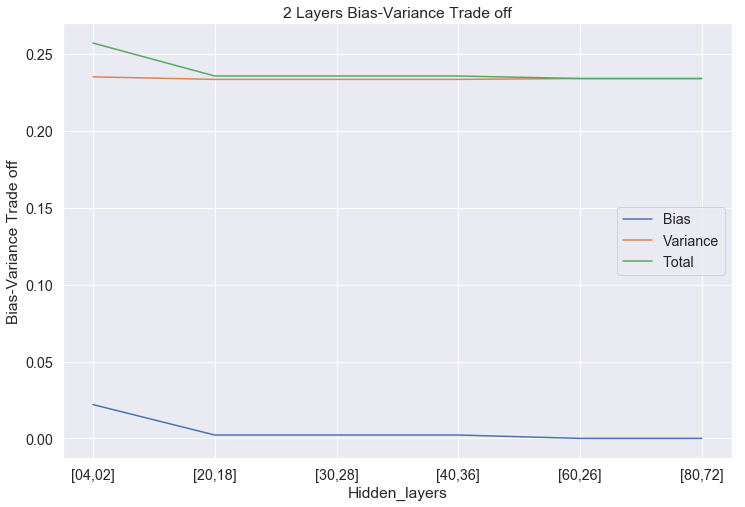

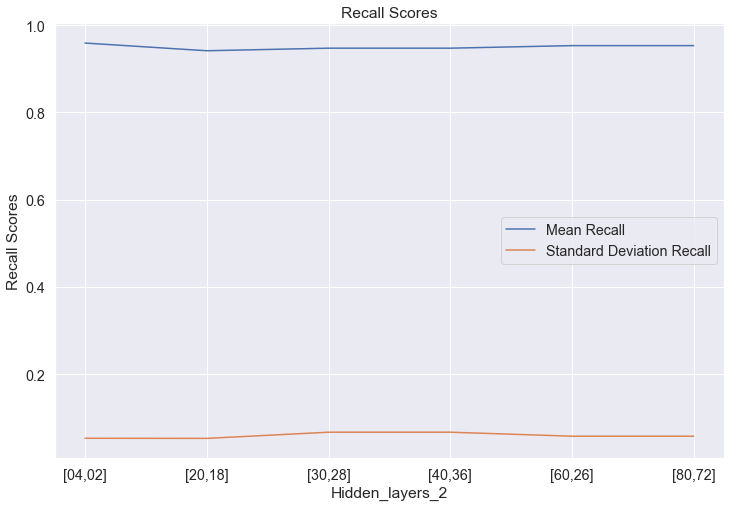

In [96]:
#first try 2 layers
hidden_layer=[[4,2],[20,18],[30,28],[40,36],[60,26],[80,72]] 
nn_bias=[]
nn_variance=[]
nn_total=[]
nn_mean_recall=[]
nn_std_recall=[]

for layer in hidden_layer:
    nn=MLPClassifier(hidden_layer_sizes=(layer),alpha=0.0001,max_iter=400)
    nn.fit(X_train, y_train)
    pred=nn.predict(X_train)
    outcomes=cross_val_score(nn,X_train,y_train,cv=10,scoring='recall')
    nn_mean_recall.append(np.mean(outcomes))
    nn_std_recall.append(np.std(outcomes))
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))


layer=('[04,02]','[20,18]','[30,28]','[40,36]','[60,26]','[80,72]')
bv=plt.figure(1)
sns.lineplot(x=layer,y=nn_bias)
sns.lineplot(x=layer,y=nn_variance)
sns.lineplot(x=layer,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("2 Layers Bias-Variance Trade off")
plt.xlabel("Hidden_layers")
plt.ylabel("Bias-Variance Trade off")
bv.show()

rc=plt.figure(2)
sns.lineplot(x=layer,y=nn_mean_recall)
sns.lineplot(x=layer,y=nn_std_recall)
plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("Hidden_layers_2")
plt.ylabel("Recall Scores")
rc.show()

In [97]:
hidden_layer[nn_total.index(min(nn_total))] #the value that results in minimum total error

[60, 26]

In [98]:
hidden_layer[nn_mean_recall.index(max(nn_mean_recall))] #the value that results in maximum recall mean

[4, 2]

In [99]:
hidden_layer[nn_std_recall.index(min(nn_std_recall))] #the value that results in minimum recall std

[20, 18]

## hidden_layer=(20,18) was chose as it is optimal for both recall mean and std.. As for the total error, the difference between it and the optimal value are very small.

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


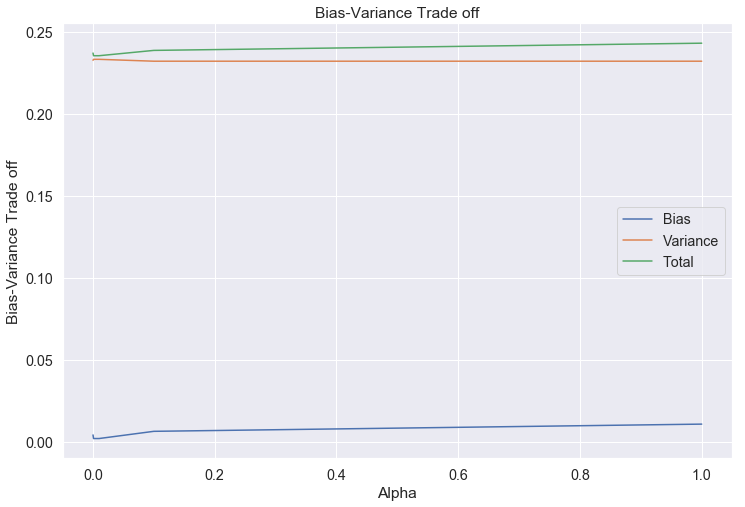

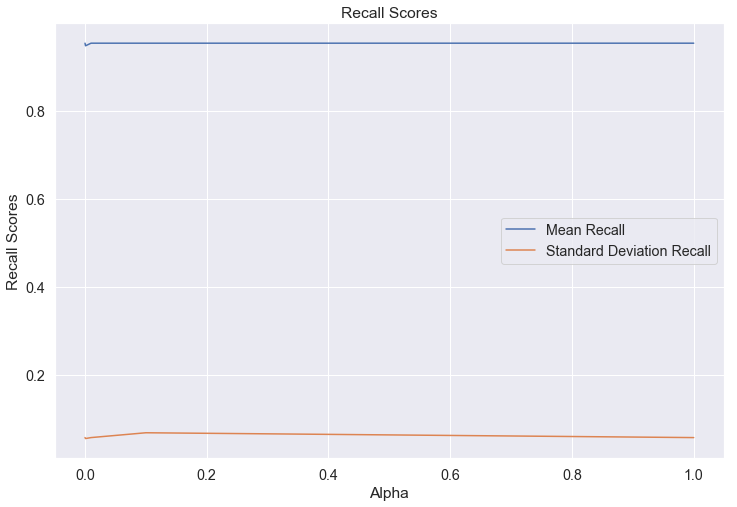

In [100]:
#for 1 layers
Alpha=[0.0001,0.001,0.01,0.1,1] 
nn_bias=[]
nn_variance=[]
nn_total=[]
nn_mean_recall=[]
nn_std_recall=[]
for a in Alpha:
    nn=MLPClassifier(hidden_layer_sizes=(100,),alpha=a,max_iter=400)
    nn.fit(X_train, y_train)
    pred=nn.predict(X_train)
    outcomes=cross_val_score(nn,X_train,y_train,cv=10,scoring='recall')
    nn_mean_recall.append(np.mean(outcomes))
    nn_std_recall.append(np.std(outcomes))
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))


bv=plt.figure(1)
sns.lineplot(x=Alpha,y=nn_bias)
sns.lineplot(x=Alpha,y=nn_variance)
sns.lineplot(x=Alpha,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Alpha")
plt.ylabel("Bias-Variance Trade off")
bv.show()

rc=plt.figure(2)
sns.lineplot(x=Alpha,y=nn_mean_recall)
sns.lineplot(x=Alpha,y=nn_std_recall)
plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("Alpha")
plt.ylabel("Recall Scores")
rc.show()

In [101]:
Alpha[nn_total.index(min(nn_total))] #the value that results in minimum total error

0.001

In [102]:
Alpha[nn_mean_recall.index(max(nn_mean_recall))] #the value that results in maximum recall mean

0.0001

In [103]:
Alpha[nn_std_recall.index(min(nn_std_recall))] #the value that results in minimum recall std

0.001

## alpha=0.0001 was chose for 1 hidden layer

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


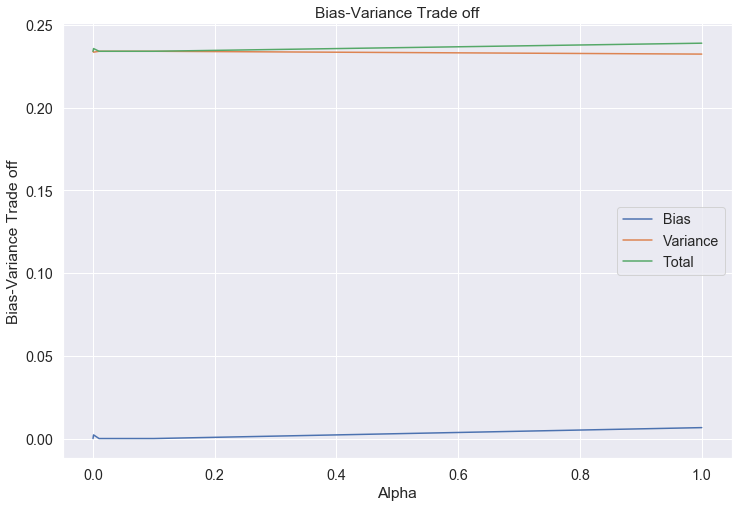

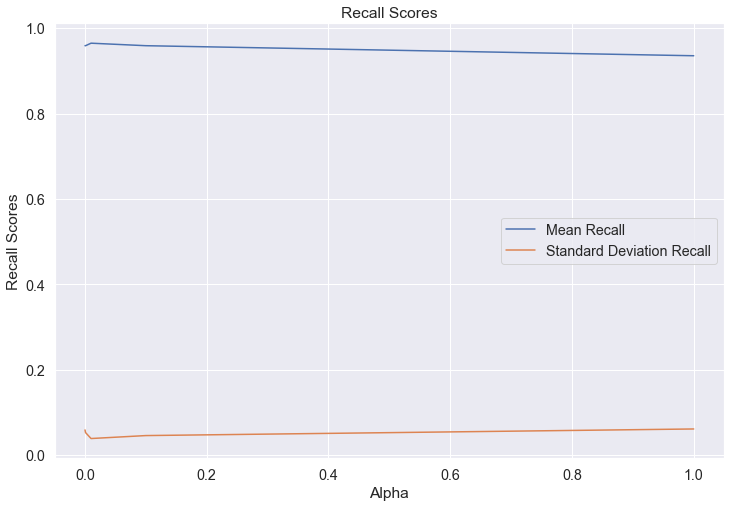

In [104]:
#for 2 layers
Alpha=[0.0001,0.001,0.01,0.1,1] 
nn_bias=[]
nn_variance=[]
nn_total=[]
nn_mean_recall=[]
nn_std_recall=[]
for a in Alpha:
    nn=MLPClassifier(hidden_layer_sizes=(30,28),alpha=a,max_iter=400)
    nn.fit(X_train, y_train)
    pred=nn.predict(X_train)
    outcomes=cross_val_score(nn,X_train,y_train,cv=10,scoring='recall')
    nn_mean_recall.append(np.mean(outcomes))
    nn_std_recall.append(np.std(outcomes))
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))


bv=plt.figure(1)
sns.lineplot(x=Alpha,y=nn_bias)
sns.lineplot(x=Alpha,y=nn_variance)
sns.lineplot(x=Alpha,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Alpha")
plt.ylabel("Bias-Variance Trade off")
bv.show()

rc=plt.figure(2)
sns.lineplot(x=Alpha,y=nn_mean_recall)
sns.lineplot(x=Alpha,y=nn_std_recall)
plt.legend(['Mean Recall','Standard Deviation Recall'])
plt.title("Recall Scores")
plt.xlabel("Alpha")
plt.ylabel("Recall Scores")
rc.show()

In [105]:
Alpha[nn_total.index(min(nn_total))] #the value that results in minimum total error

0.0001

In [106]:
Alpha[nn_mean_recall.index(max(nn_mean_recall))] #the value that results in maximum recall mean

0.01

In [107]:
Alpha[nn_std_recall.index(min(nn_std_recall))] #the value that results in minimum recall std

0.01

## alpha=0.0001 was chose for 2 hidden layers

In [108]:
nn1_tuned=MLPClassifier(hidden_layer_sizes=(100,),alpha=0.0001,max_iter=400)
nn2_tuned=MLPClassifier(hidden_layer_sizes=(20,18),alpha=0.0001,max_iter=400)
nn1_tuned.fit(X_train,y_train)
nn2_tuned.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 18), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Mean recall score: 0.9529411764705882
Standard Deviation: 0.057635052771368905
[1.         0.88235294 1.         1.         0.82352941 0.94117647
 1.         1.         0.94117647 0.94117647]


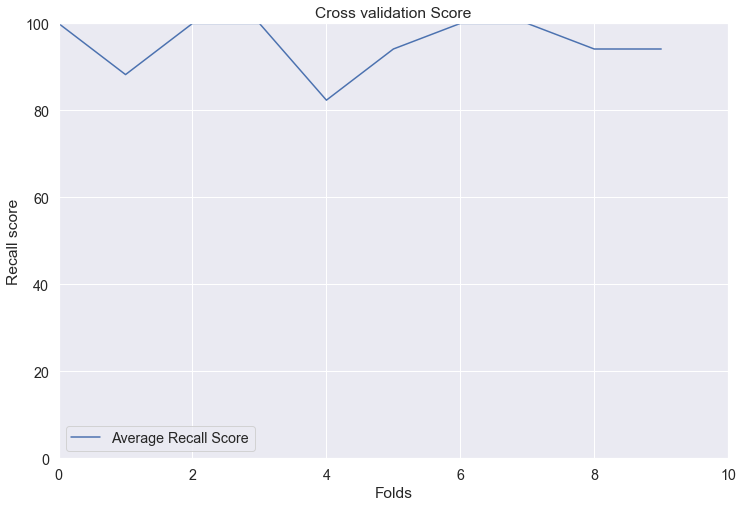

In [109]:
run_kfold(nn1_tuned)
#it performs worse

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean recall score: 0.9470588235294117
Standard Deviation: 0.06681068642117971
[1.         0.82352941 1.         1.         0.82352941 0.94117647
 1.         1.         0.94117647 0.94117647]


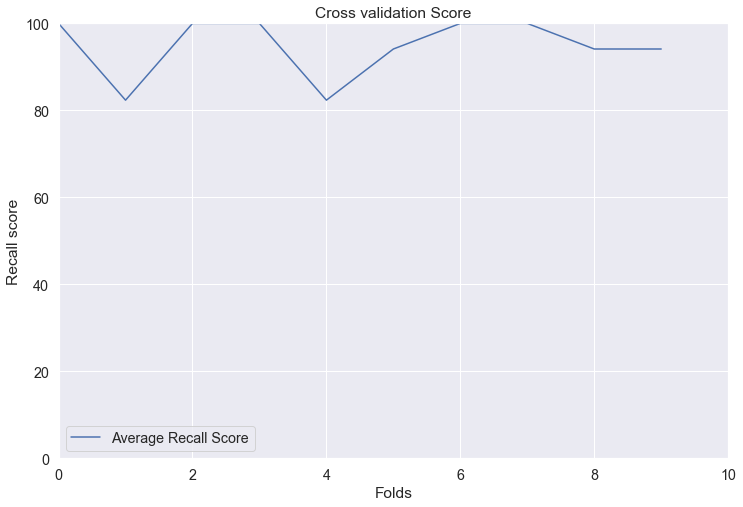

In [110]:
run_kfold(nn2_tuned)
#it performs worse

## clearly, 2 hidden layer neural network performs better

In [111]:
#store training score
outcomes=cross_val_score(nn2_tuned,X_train,y_train,cv=10,scoring='recall')
model_score['Neural Network']=[np.mean(outcomes),np.std(outcomes)]

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


*-------------------------------------------------------------------------------------------------------------------------*
### it seems 
### Random Forest with max_depth=10,n_estimators=64  
### XGBoost with max_depth=4, learning_rate=0.8, n_estimators=80 
### KNN with n_neighbors=3 
### Neural Network with hidden_layer_sizes=(20,18),alpha=0.0001,max_iter=400
### perform the best in the training set 

# Validation and Comparison

In [112]:
#first, let's check out the training result
model_score

,Random Forest,XGBoost,KNN,Neural Network
Recall Mean,0.929412,0.958824,0.935294,0.958824
Recall Std.,0.051281,0.045943,0.061414,0.059117


Text(0, 0.5, 'Scores')

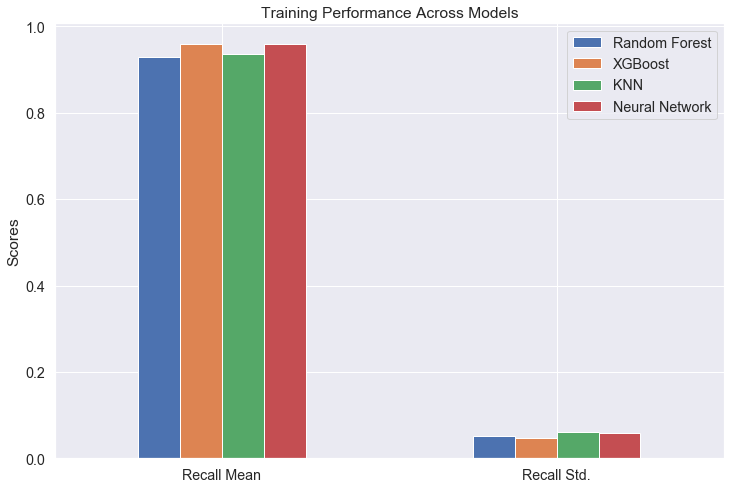

In [113]:
#Plot the result
model_score.plot(kind='bar',rot=0)
plt.title("Training Performance Across Models")
plt.ylabel("Scores")


## looks like XGBoost and Neural Network perform the best in training, now let's check out how they perform in test set

In [114]:
rfc_tuned=RandomForestClassifier(criterion='gini', max_depth=10,n_estimators=64, random_state=0)
rfc_tuned.fit(X_train, y_train)
xgb_tuned=xgb_tuned=XGBClassifier(max_depth=4,learning_rate=0.8,n_estimators=80,random_state=42)
xgb_tuned.fit(X_train, y_train)
knn_tuned=KNeighborsClassifier(n_neighbors=3)
knn_tuned.fit(X_train, y_train)
nn_tuned=MLPClassifier(hidden_layer_sizes=(20,18),alpha=0.0001,max_iter=400)
nn_tuned.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 18), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [115]:
pred_rfc=rfc_tuned.predict(X_test)
pred_xgb=xgb_tuned.predict(X_test)
pred_knn=knn_tuned.predict(X_test)
pred_nn=nn_tuned.predict(X_test)
accuracy_rfc=accuracy_score(y_test,pred_rfc)
accuracy_xgb=accuracy_score(y_test,pred_xgb)
accuracy_knn=accuracy_score(y_test,pred_knn)
accuracy_nn=accuracy_score(y_test,pred_nn)

print ('The accuracy of Random Forest is',accuracy_rfc)
print ('The accuracy of XGBoost is',accuracy_xgb)
print ('The accuracy of KNN is',accuracy_knn)
print ('The accuracy of Neural Network is',accuracy_nn)

The accuracy of Random Forest is 0.9473684210526315
The accuracy of XGBoost is 0.9736842105263158
The accuracy of KNN is 0.9473684210526315
The accuracy of Neural Network is 0.9824561403508771


In [116]:
print('Random Forest classification report\n***********************************\n',classification_report(y_test,pred_rfc))
print('XGBoost classification report\n***********************************\n',classification_report(y_test,pred_xgb))
print('KNN classification report\n***********************************\n',classification_report(y_test,pred_knn))
print('Neural Network classification report\n***********************************\n',classification_report(y_test,pred_nn))

Random Forest classification report
***********************************
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

   micro avg       0.95      0.95      0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

XGBoost classification report
***********************************
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

   micro avg       0.97      0.97      0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

KNN classification report
***********************************
               precision    recall  f1-score   support

           0       0.93      0.99      0.96        72
           1       0.97      0.88 

C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\Ween\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 864x576 with 0 Axes>

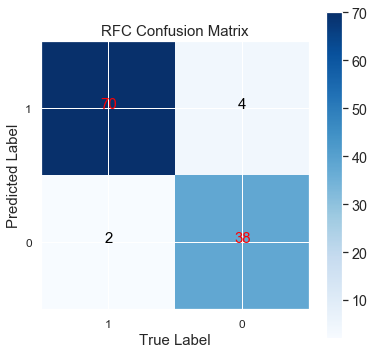

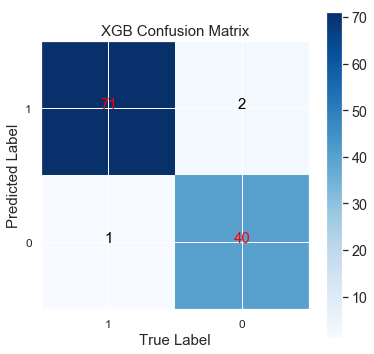

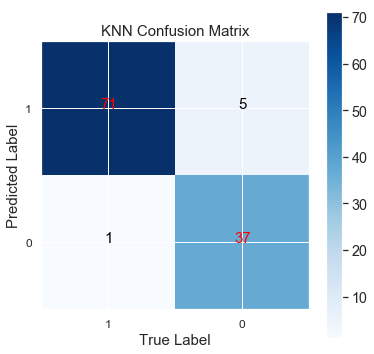

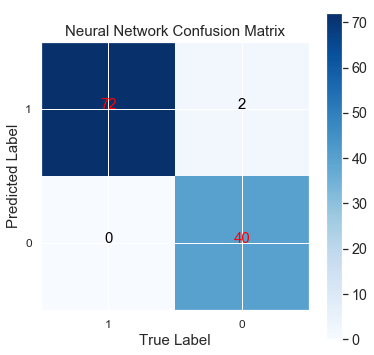

In [117]:
#Random Forest Classifier Confusion Matrix
rfc=plt.figure(1)
cm=confusion_matrix(pred_rfc,y_test, labels=[0,1])

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('RFC Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique(), fontsize=12)
plt.yticks(tick_marks, y.unique(), fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 5:
            color = 'red'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)
rfc.show()

#XGBoost Classifier Confusion Matrix
xgb=plt.figure(2)
cm=confusion_matrix(pred_xgb,y_test, labels=[0,1])

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('XGB Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique(), fontsize=12)
plt.yticks(tick_marks, y.unique(), fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 5:
            color = 'red'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)
xgb.show()

#KNN Confusion Matrix
knn=plt.figure(3)
cm=confusion_matrix(pred_knn,y_test, labels=[0,1])

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique(), fontsize=12)
plt.yticks(tick_marks, y.unique(), fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 5:
            color = 'red'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)
        
knn.show()

#Neural Network Confusion Matrix
nn=plt.figure(4)
cm=confusion_matrix(pred_nn,y_test, labels=[0,1])

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique(), fontsize=12)
plt.yticks(tick_marks, y.unique(), fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 5:
            color = 'red'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)
        
nn.show()


# Discussion
- something learned during the project:
 - balance always better than perform well in certain dataset. Balance between bias-variance tradeoff, accuracy score and std of accuracy through out the folds in Kfold cross validation, so that we can have a stable and reliable model that we have confident in it when it is put to test.
 - strong learning model does not always is the one best choice, sometime simpler and quicker with similar power is a better choice as if it is a large project, the computational power is a great measurement of the model to keep in mind.

- something to do in the future:
 - after last night's presentation, I think I should try build some model without applying PCA first, and compare the result with using PCA. And one more perk with that is I can use the feature importance to see which features have strong effect on the output.


I have tight up a bit on the notebook, hopefully my flow makes more sense than what I present last night, which I wish I have done in a complete different and much more informative way.

I have learned a lot in the course. Thank you both and wish all the best!

--Wenjia Wu